**Корректность проверена на Python 3.6:**
+ numpy 1.15.4
+ matplotlib 3.0.2
+ pandas 0.23.4

# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузим датасет, а затем убедимся в корректности считывания данных.

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

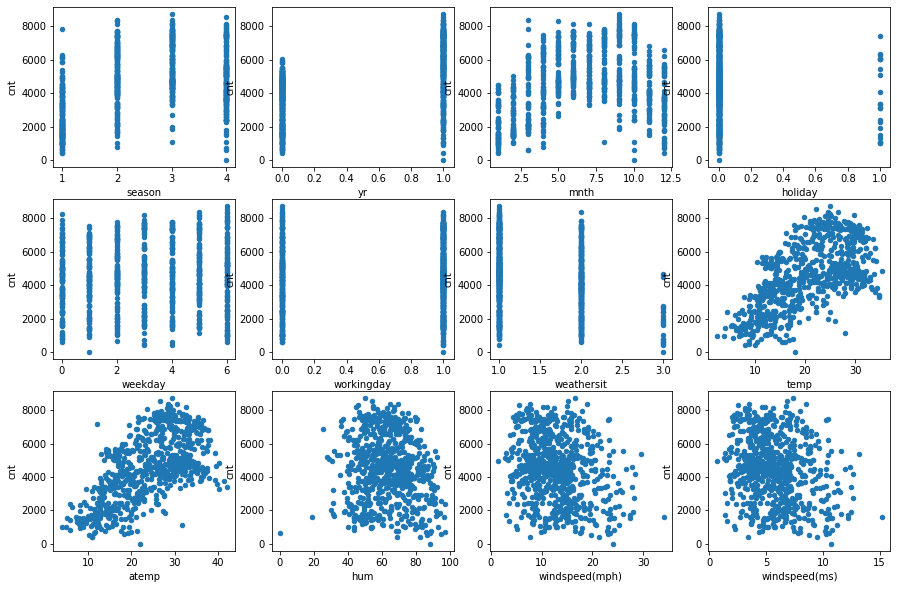

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

__Блок 1. Ответьте на вопросы__:
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: видно, что в 5-10 месяцы (май-октябрь) среднее количество прокатов в день значительно выше, чем в остальные месяцы. Также, в весенние и осенние месяцы наблюдается большой разброс между максимальным числом прокатов и минимальным, что может быть объяснено переменчивой погодой. В то же время, летом разброс между максимумом и минимумом количества арендованных велосипедов меньше, но между тем месячные максимумы летних месяцев ниже осенних/весенних. Как мне кажется, это объясняется более стабильной, но более жаркой погодой
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: количество прокатов скорее всего линейно зависит от температуры в градусах Цельсия (temp) и от ощущаемой температуры в градусах Цельсия (atemp), также, возможно, число прокатов линейно зависит от влажности (hum)

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [4]:
#просмотрим матрицу корреляций
df.corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659


In [5]:
#найдем коэффициенты коррелиции каждого признака из датафрейма с целевым признаком cnt

#создаем объект Series, содержащий значения признака cnt на всех объектах выборки. Этот объект будем
#использовать как аргумент функции corrwith()
df_series = pd.Series(df['cnt'])
#создаем ещё один датафрейм - без признака cnt
df_features = df.drop(['cnt'], axis = 1)
#находим попарну корреляцию признаков из датафрейма и целевого признака cnt
features_cnt_corr = df_features.corrwith(df_series, axis = 0, method = 'pearson')
features_cnt_corr

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [6]:
# Код 1.2 
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
pair_corr_df = df.drop(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], axis = 1)
pair_corr_df.corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [7]:
# Код 1.3
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
#Перемешаем и отмасштабируем выборку
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

df_X = pd.DataFrame(X)
df_X.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.447350,0.998633,-0.440589,-0.171981,0.500513,0.679706,1.110427,0.353232,0.386172,0.986702,-0.733299,-0.733299
1,-1.348213,0.998633,-1.310268,-0.171981,-1.496077,-1.471225,-0.726048,-1.181998,-1.265253,-1.530890,0.190365,0.190365
2,-0.447350,-1.001369,-0.730482,-0.171981,1.498809,-1.471225,1.110427,-0.986109,-0.974623,0.181660,0.085994,0.085994
3,1.354375,-1.001369,1.008875,-0.171981,0.999661,0.679706,1.110427,-0.899555,-0.955126,-0.295514,0.503491,0.503491
4,0.453512,-1.001369,-0.150697,-0.171981,-0.996930,0.679706,1.110427,1.022903,0.998774,0.213859,-1.070416,-1.070416


Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [10]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [11]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns

#создаем объект регрессора
linear_regressor = linear_model.LinearRegression()
#обучаем объект на всех данных
linear_regressor.fit(X, y)

print('weights for linear regressor without any kind of regularization being applied:')
for feature, weight in zip(df_features, linear_regressor.coef_):
    print('feature "{}" has weight {}'.format(feature, weight))

weights for linear regressor without any kind of regularization being applied:
feature "season" has weight 570.8681698112806
feature "yr" has weight 1021.9637175294769
feature "mnth" has weight -141.30232005185658
feature "holiday" has weight -86.76357810238395
feature "weekday" has weight 137.2291962130855
feature "workingday" has weight 56.38823527436251
feature "weathersit" has weight -330.2316126526911
feature "temp" has weight 367.4749136050979
feature "atemp" has weight 585.5563613048682
feature "hum" has weight -145.60790584172227
feature "windspeed(mph)" has weight 12458830091266.607
feature "windspeed(ms)" has weight -12458830091465.062


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [12]:
from sklearn.linear_model import Lasso, Ridge

In [13]:
# Код 2.2 
# Обучите линейную модель с L1-регуляризацией и выведите веса
lasso_regressor = linear_model.Lasso()
lasso_regressor.fit(X, y)

print('Weights for lasso regressor:')
for feature, weight in zip(df_features, lasso_regressor.coef_):
    print('feature "{}" has weight {}'.format(feature, weight))

Weights for lasso regressor:
feature "season" has weight 560.241616030887
feature "yr" has weight 1019.4634940657196
feature "mnth" has weight -128.7306270367875
feature "holiday" has weight -86.15278133371096
feature "weekday" has weight 137.34789390496329
feature "workingday" has weight 55.21237064135668
feature "weathersit" has weight -332.3698569623488
feature "temp" has weight 376.3632362096987
feature "atemp" has weight 576.5307935045507
feature "hum" has weight -144.12915500348595
feature "windspeed(mph)" has weight -197.13968940248608
feature "windspeed(ms)" has weight -2.8049652690829766e-08


In [14]:
# Код 2.3 
# Обучите линейную модель с L2-регуляризацией и выведите веса
ridge_regressor = linear_model.Ridge()
ridge_regressor.fit(X, y)

print('Weights for ridge regressor:')
for feature, weight in zip(df_features, ridge_regressor.coef_):
    print('feature "{}" has weight {}'.format(feature, weight))

Weights for ridge regressor:
feature "season" has weight 563.0645722520176
feature "yr" has weight 1018.9483787875288
feature "mnth" has weight -131.87332028247695
feature "holiday" has weight -86.74609799709272
feature "weekday" has weight 138.005111178719
feature "workingday" has weight 55.90311037506445
feature "weathersit" has weight -332.34978849907355
feature "temp" has weight 386.45788919194615
feature "atemp" has weight 566.3470470600289
feature "hum" has weight -145.0713272986722
feature "windspeed(mph)" has weight -99.25944108175416
feature "windspeed(ms)" has weight -99.25944115437945


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [15]:
# Код 3.1 
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso
# а затем обучите Ridge и запишите веса в coefs_ridge.
for i in range(len(alphas)):
    lasso_coef_check = linear_model.Lasso(alpha = alphas[i])
    lasso_coef_check.fit(X, y)
    coefs_lasso[i] = lasso_coef_check.coef_

for j in range (len(alphas)):
    ridge_coef_check = linear_model.Ridge(alpha = alphas[j])
    ridge_coef_check.fit(X, y)
    coefs_ridge[j] = ridge_coef_check.coef_

In [16]:
#Выведем полученную матрицу коэффициентов
print(coefs_lasso)
print(coefs_lasso.shape)

[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80496527e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29876665e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41641619e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62774544e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -2.78783243e-08]
 [ 2.

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

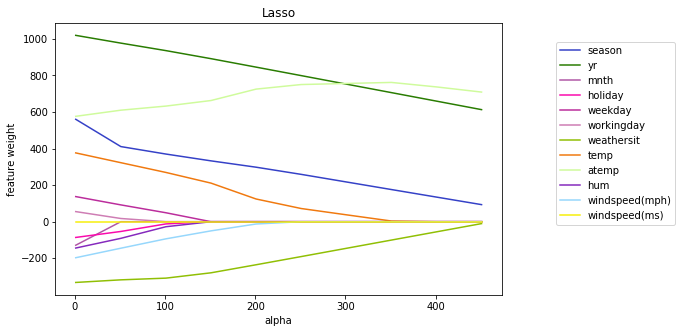

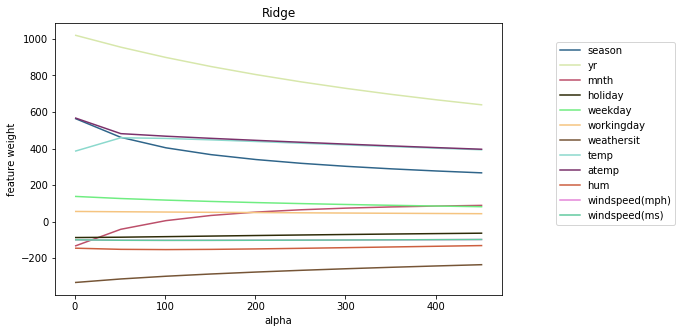

In [17]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: В ячейке ниже я вывел результаты действия регуляризаторов Ridge и Lasso. Как видно, при почти одинаковых начальных весах для признака season, конечное значение весового коэффициента при признаке season для Lasso почти в три раза меньше, чем для Ridge. Если посмотреть на графики, для некоторых других признаков наблюдается та же картина. Исходя из этого можно сказать, что Lasso уменьшает веса агрессивнее
2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: L1-регуляризатор представляет собой норму вектора весов. При увеличении значения alpha L1-регуляризатор начнем занулять веса при некоторых признаках, т.к. вклад этого веса в значение регуляризатора будет больше той дополнительной ошибки, которая возникнет при вычислении функционала с "зануленным" коэффициентом. Таким образом, будет более выгодным просто избавляться от некоторых весов, т.к. при этом ошибка будет уменьшаться. Однако, при очень больших значениях alpha, модель может посчитать более выгодным просто избавиться от всех весовых коэффициентов
3. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: Как видно из графиков, Lasso-регуляризатор исключил признак windspeed(ms) - при любых значениях альфа значение веса при признаке равно нулю. Для Ridge-регуляризатора же значение весов при обоих признаках windspeed держится примерно на уровне 100 для любых значений альфа. 
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Для отбора неинформативных однозначено лучше подойдет Lasso-регуляризатор. Он практически сразу вычеркнул несколько признаков, неинформативных с чисто логической точки зрения, в то время, как Ridge-регуляризатор не вычеркнул ни один признак. Даже при альфа = 451 ни один из весов не имеет значение 0

In [18]:
#коэффициенты при L1-регуляризации для первого и последнего значения альфа для признака 'season'
print('Веса для максимального и минимального значений альфа для L1-регуляризации равны \
{} и {} соответственно'.format(round(coefs_lasso[0][0],2), round(coefs_lasso[9][0],2))) 
#коэффициенты при L2-регуляризации для первого и последнего значения альфа для признака 'season'
print('Веса для максимального и минимального значений альфа для L2-регуляризации равны \
{} и {} соответственно'.format(round(coefs_ridge[0][0],2), round(coefs_ridge[9][0],2))) 

Веса для максимального и минимального значений альфа для L1-регуляризации равны 560.24 и 93.35 соответственно
Веса для максимального и минимального значений альфа для L2-регуляризации равны 563.06 и 267.03 соответственно


Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [19]:
from sklearn.linear_model import LassoCV

In [20]:
# Код 3.2
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
lasso_alpha_regressor = linear_model.LassoCV(alphas = alphas, cv =3).fit(X, y)
mse_path = lasso_alpha_regressor.mse_path_
#округлим полученные значения mse для удобства
for i in range(len(alphas)):
    for j in range(3):
        mse_path[i][j] = round(mse_path[i][j], 2)
print(mse_path)

[[863936.51 826364.12 862993.3 ]
 [860479.32 821110.18 853075.14]
 [857344.84 816153.28 843628.81]
 [854526.74 811496.35 834654.45]
 [852024.62 807139.4  826152.16]
 [849838.19 803082.42 818122.02]
 [847967.16 799325.43 810564.07]
 [846411.32 795868.41 803478.37]
 [845170.46 792711.37 796864.93]
 [844244.41 789854.31 790723.78]
 [843633.03 787297.23 785058.7 ]
 [843336.18 785040.13 779861.12]
 [843353.77 783083.   775139.9 ]
 [843616.45 781425.86 770886.44]
 [843608.2  780068.69 767109.44]
 [844145.56 777586.36 763800.36]
 [845219.35 775290.92 760967.79]
 [846828.77 773628.86 755626.71]
 [848973.8  772598.5  749620.89]
 [851701.89 878936.94 745668.61]]


In [21]:
#найдем средние значение MSE для каждого значения alpha и запишем их в список
mean_mse_for_alpha = []
for line in mse_path:
    mean_mse_for_alpha.append(round((sum(line)/len(line)), 2))
print(mean_mse_for_alpha)

[851097.98, 844888.21, 839042.31, 833559.18, 828438.73, 823680.88, 819285.55, 815252.7, 811582.25, 808274.17, 805329.65, 802745.81, 800525.56, 798642.92, 796928.78, 795177.43, 793826.02, 792028.11, 790397.73, 825435.81]


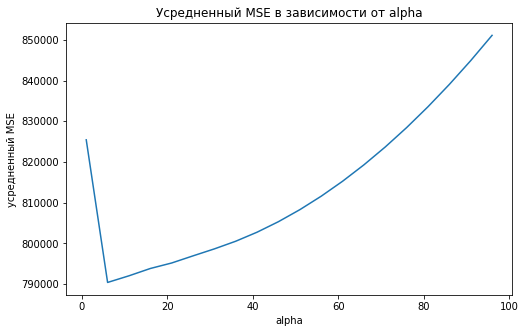

In [22]:
#Визуализируем зависимость среднего MSE по кросс-валидации на три фолда от значения alpha 
#для модели линейной регрессии с L1-регуляризатором
plt.figure(figsize=(8, 5))
plt.plot(lasso_alpha_regressor.alphas_, mean_mse_for_alpha)
plt.xlabel("alpha")
plt.ylabel("усредненный MSE")
plt.title("Усредненный MSE в зависимости от alpha")
plt.show()

In [23]:
#Выведем выбранное алгоритмом alpha, при котором достигается минимальное значение MSE
print('Наименьшее значение MSE достигается при alpha, равной {}'.format(lasso_alpha_regressor.alpha_))
#выведем так же порядок, в котором регрессор проходит по альфам, чтобы можно было сопоставить результат с тем
#что записано в mse_path
print(lasso_alpha_regressor.alphas_)

Наименьшее значение MSE достигается при alpha, равной 6
[96 91 86 81 76 71 66 61 56 51 46 41 36 31 26 21 16 11  6  1]


Если взглянуть на матрицу mse_path, видно, что минимальное среднее mse по строкам действительно достигается в предпоследней строчке, то есть в строке, для которой alpha = 6

In [24]:
#выведем пары "признак-коэффициент"
print('Значения весов признаков при оптимальном значении alpha:')
for feature, coef in zip (df_features, lasso_alpha_regressor.coef_):
    print ("Вес признака {} равен {}".format(feature, round(coef, 3)))

Значения весов признаков при оптимальном значении alpha:
Вес признака season равен 532.019
Вес признака yr равен 1015.06
Вес признака mnth равен -100.04
Вес признака holiday равен -83.294
Вес признака weekday равен 132.504
Вес признака workingday равен 51.557
Вес признака weathersit равен -330.56
Вес признака temp равен 370.68
Вес признака atemp равен 581.397
Вес признака hum равен -140.007
Вес признака windspeed(mph) равен -191.771
Вес признака windspeed(ms) равен -0.0


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [25]:
# Код 3.3
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).

first_col_mse = []
for i in range(len(mse_path)):
    first_col_mse.append(mse_path[i][0])
    
second_col_mse = []
for j in range(len(mse_path)):
    second_col_mse.append(mse_path[j][1])
    
third_col_mse = []
for k in range(len(mse_path)):
    third_col_mse.append(mse_path[k][2])

#создадим список, в который запишем индексы строк, 
#в которых находятся минимальные значения MSE по каждой колонке
alphas_indeces = []
alphas_indeces.append(first_col_mse.index(min(first_col_mse)))
alphas_indeces.append(second_col_mse.index(min(second_col_mse)))
alphas_indeces.append(third_col_mse.index(min(third_col_mse)))

print(alphas_indeces)

alphas_list = lasso_alpha_regressor.alphas_[alphas_indeces]
print('Значения alpha, соответствующие минимумам MSE по столбцам') 
print('первый столбец: {}'.format(alphas_list[0]))
print('второй столбец: {}'.format(alphas_list[1]))
print('третий столбец: {}'.format(alphas_list[2]))

[11, 18, 19]
Значения alpha, соответствующие минимумам MSE по столбцам
первый столбец: 41
второй столбец: 6
третий столбец: 1


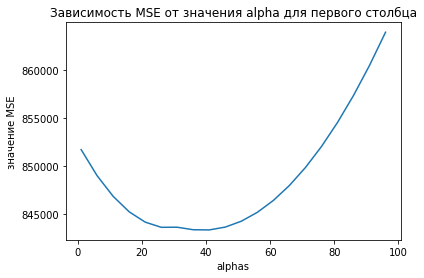

In [26]:
# На трех отдельных графиках визуализируйте столбцы .mse_path_

plt.plot(lasso_alpha_regressor.alphas_, first_col_mse)
plt.xlabel('alphas')
plt.ylabel('значение MSE')
plt.title('Зависимость MSE от значения alpha для первого столбца')
plt.show()

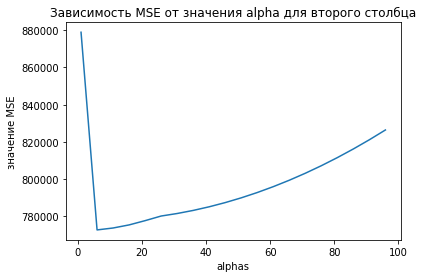

In [27]:
plt.plot(lasso_alpha_regressor.alphas_, second_col_mse)
plt.xlabel('alphas')
plt.ylabel('значение MSE')
plt.title('Зависимость MSE от значения alpha для второго столбца')
plt.show()

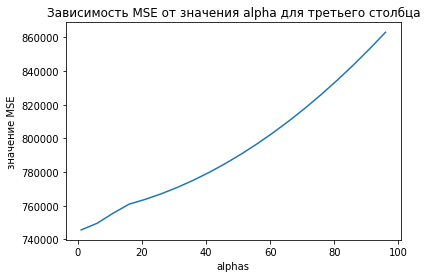

In [28]:
plt.plot(lasso_alpha_regressor.alphas_, third_col_mse)
plt.xlabel('alphas')
plt.ylabel('значение MSE')
plt.title('Зависимость MSE от значения alpha для третьего столбца')
plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы:__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: признаки с наибольшими положительными коэффициентами: yr(coef = 1015,06), atemp(coef = 581,397), season(coef = 532,019), temp(coef = 370,68). Все значенияя коэффициентов взяты для оптимального значения alpha. На графиках хорошо видна возрастающая зависимость целевого признака cnt от выписанных признаков. Однако, не всегда логично утверждать, что чем больше значения этих признаков, тем больше людей захотят взять в прокат велосипед. Например, для температурных признаков из графиков видно, что при температуре порядка 40-ка градусов прокат меньше, чем при 25-30. Также, самым важным признаком оказался yr(год), что вообще-то совсем не очевидно. Скорее всего так получилось из-за того, что во второй год (метка 1) погода в целом была намного лучше, чем в первый (метка 0), этим и обусловлена разница в среднем количестве прокатов в день, благодаря этому модель и выбрала данный признак "самым важным". Конечно, это также может быть обусловлено тем, что элементарно большее количество людей узнало о возможности взять велосипед на прокат, или с увеличением количества велосипедов, отдаваемых компанией под прокат. Но всё же, чисто логически нельзя утверждать, что значение признака cnt должно увеличиваться с ростом значения признака yr, то есть, что прокат велосипедов обязательно будет расти из года в год.
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ:признаки с наибольшими отрицательными коэффициентами: weathersit(coef = -330,56), windspeed(coef = 191,771), hum(coef = -140,007). Для двух последних признаков отрицательная зависимость выражена неярко, но всё же она видна, что вполне логично. Признак weathersit работает таким образом, что чем хуже погода, тем выше значени признака, так что убывающая линейная зависимость от него целевого признака cnt также очевидна. 
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: Для оптимального значения alpha только один признак имеет нулевое значение весового коэффициента - windspeed(ms), т.к. он логически дублирует признак windspeed(mph), хотя, логически, скорость ветра конечно влияет на спрос на велосипеды. По графику зависимости весов в модели Lasso-регуляризации от значения alpha видно, что достаточно быстро "зануляются" признаки mnth и workingday. Из графиков зависимости cnt от признаков видно, что для признака mnth на всей области его значений нет возрастающей зависимости, что логично, т.к. крайние значения представляют собой самые холодные месяцы, а значения в середине интервала - самые теплые. Поэтому при выбранном соответствии месяцев числовым значениям признака, данный признак становится практически неинформативным для линейной модели. Из графиков блока "Знакомство с данными" также видно, что количество прокатов в рабочие дни и нерабочие несильно отличается, в результате чего L1-регуляризатор при увеличении alpha начинает считать этот признак неинформативным.   

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.